**Online Evaluation: A/B Testing & Bandits**

Demonstrate understanding of online evaluation and exploration in a simulated environment. Outline the methodology for A/B testing of recommender algorithms, and implement at least two multi-armed bandit strategies (e.g., eps-greedy, UCB, Thompson Sampling) to compare against static policies

In [1]:
import sys
sys.path.append("../src")
sys.path.append("../src/evaluation")
sys.path.append("../src/models")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from numba import njit, prange
from utils.data_loader import MovieLensDataLoader

loader = MovieLensDataLoader()
train, val, test = loader.load_splits()
_, movies, _ = loader.load_raw_data()

n_users = train['user_id'].max() + 1
n_items = train['item_id'].max() + 1
THRESHOLD = 4.0

Train: 797,758 | Val: 97,383 | Test: 105,068
Loaded 1,000,209 ratings
Loaded 3,883 movies
Loaded 6,040 users


In [3]:
# Build test ground truth: user -> {item: rating}
test_gt = defaultdict(dict)
for _, row in test.iterrows():
    test_gt[row['user_id']][row['item_id']] = row['rating']

test_users = sorted(test_gt.keys())

In [4]:
# Build Recommender policies
# Policy 0: popularity
item_counts = train.groupby('item_id').size()
pop_ranked = item_counts.sort_values(ascending=False).index.tolist()
user_seen = train.groupby('user_id')['item_id'].apply(set).to_dict()

def popularity_policy(user_id, k=10):
    seen = user_seen.get(user_id, set())
    return [iid for iid in pop_ranked if iid not in seen][:k]

In [5]:
# Policy 1: BPR-MF
pos_df = train[train['rating'] >= THRESHOLD]
user_pos_items = pos_df.groupby('user_id')['item_id'].apply(set).to_dict()

In [6]:
@njit(fastmath=True)
def bpr_epoch_nb(user_ids, pf, offs, cnts, n_items, uf, itf, ub, ib, lr, reg, ns):
    loss = 0.0
    for _ in range(ns):
        u = np.random.randint(0, len(offs))
        uid = user_ids[u]; c = cnts[u]
        if c == 0: continue
        o = offs[u]
        pi = pf[o + np.random.randint(0, c)]
        ni = np.random.randint(0, n_items)
        for _ in range(10):
            found = False
            for k in range(c):
                if pf[o + k] == ni: found = True; break
            if not found: break
            ni = np.random.randint(0, n_items)
        x = (ub[uid] + ib[pi] + np.dot(uf[uid], itf[pi])) - (ub[uid] + ib[ni] + np.dot(uf[uid], itf[ni]))
        sig = 1.0 / (1.0 + np.exp(x))
        loss += np.log(1.0 / (1.0 + np.exp(-x)) + 1e-10)
        uf[uid] += lr * (sig * (itf[pi] - itf[ni]) - reg * uf[uid])
        itf[pi] += lr * (sig * uf[uid] - reg * itf[pi])
        itf[ni] += lr * (-sig * uf[uid] - reg * itf[ni])
        ib[pi] += lr * (sig - reg * ib[pi])
        ib[ni] += lr * (-sig - reg * ib[ni])
    return loss / ns

In [7]:
np.random.seed(42)
nf = 64
uf = np.random.normal(0, 0.01, (n_users, nf))
itf = np.random.normal(0, 0.01, (n_items, nf))
ub, ib = np.zeros(n_users), np.zeros(n_items)

uids_arr, pf_arr, offs_arr, cnts_arr = [], [], [], []
o = 0
for uid in range(n_users):
    items = list(user_pos_items.get(uid, []))
    uids_arr.append(uid); offs_arr.append(o); cnts_arr.append(len(items))
    pf_arr.extend(items); o += len(items)
uids_arr = np.array(uids_arr, np.int64); pf_arr = np.array(pf_arr, np.int64)
offs_arr = np.array(offs_arr, np.int64); cnts_arr = np.array(cnts_arr, np.int64)

for ep in range(30):
    bpr_epoch_nb(uids_arr, pf_arr, offs_arr, cnts_arr, n_items, uf, itf, ub, ib, 0.01, 0.001, len(pf_arr)*5)

In [8]:
def bpr_policy(user_id, k=10):
    if user_id >= n_users: return []
    scores = ib + itf @ uf[user_id]
    seen = user_seen.get(user_id, set())
    for s in seen: scores[s] = -np.inf
    tk = np.argpartition(scores, -k)[-k:]
    tk = tk[np.argsort(scores[tk])[::-1]]
    return [int(i) for i in tk if scores[i] > -np.inf][:k]

In [9]:
pop_scores = np.zeros(n_items)
max_pop = item_counts.max()
for iid, c in item_counts.items():
    if iid < n_items:
        pop_scores[iid] = np.log1p(c) / np.log1p(max_pop)

In [10]:
def hybrid_policy(user_id, k=10, alpha=0.8):
    if user_id >= n_users: return popularity_policy(user_id, k)
    bpr_sc = ib + itf @ uf[user_id]
    # min-max normalize
    mask = np.ones(n_items, dtype=bool)
    seen = user_seen.get(user_id, set())
    for s in seen: mask[s] = False
    valid = bpr_sc[mask]
    mn, mx = valid.min(), valid.max()
    if mx - mn > 1e-10:
        bpr_norm = (bpr_sc - mn) / (mx - mn)
    else:
        bpr_norm = np.zeros(n_items)
    final = alpha * bpr_norm + (1 - alpha) * pop_scores
    for s in seen: final[s] = -np.inf
    tk = np.argpartition(final, -k)[-k:]
    tk = tk[np.argsort(final[tk])[::-1]]
    return [int(i) for i in tk if final[i] > -np.inf][:k]

In [11]:
# Policy 3: Random
all_items = list(range(n_items))
def random_policy(user_id, k=10):
    seen = user_seen.get(user_id, set())
    candidates = [i for i in all_items if i not in seen]
    chosen = np.random.choice(candidates, size=min(k, len(candidates)), replace=False)
    return chosen.tolist()

policies = [popularity_policy, bpr_policy, hybrid_policy, random_policy]
policy_names = ["Popularity", "BPR-MF", "Hybrid", "Random"]
n_policies = len(policies)

In [12]:
# reward function
# simulated reward: fraction of recommended items the user rated >= threshold in test
def compute_reward(user_id, recommended_items):
    gt = test_gt.get(user_id, {})
    if not recommended_items:
        return 0.0
    hits = sum(1 for iid in recommended_items if gt.get(iid, 0) >= THRESHOLD)
    return hits / len(recommended_items)

**Multi-Armed Bandits**

We implement three distinct strategies to solve the exploration-exploitation dilemma:
1. **$\epsilon$-Greedy:** Explores uniformly at random with probability $\epsilon$, otherwise exploits the arm with the highest historical mean
2. **UCB1 (Upper Confidence Bound):** Deterministically selects arms based on a combination of empirical mean and an uncertainty bound that grows with time but shrinks the more an arm is pulled
3. **Thompson Sampling:** A Bayesian approach that models the reward distribution of each arm using a Beta distribution. It naturally balances exploration and exploitation by sampling from these posteriors

In [13]:
class EpsilonGreedy:
    # epsilon-greedy: explore with probability epsilon, exploit best arm otherwise
    def __init__(self, n_arms, epsilon=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)   # Tracks how many times each arm was pulled
        self.rewards = np.zeros(n_arms)  # Tracks total cumulative reward for each arm
    
    def select_arm(self):
        # 1. Explore: If random number is < epsilon, OR if an arm has never been pulled
        if np.random.random() < self.epsilon or np.min(self.counts) == 0:
            return np.random.randint(self.n_arms)
        
        # 2. Exploit: Calculate empirical means and pick the highest
        return np.argmax(self.rewards / np.maximum(self.counts, 1))
    
    def update(self, arm, reward):
        # Update internal state after receiving feedback from the environment
        self.counts[arm] += 1
        self.rewards[arm] += reward

In [14]:
class UCB1:
    # Upper Confidence Bound: balances exploitation (mean reward) with exploration 
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.rewards = np.zeros(n_arms)
        self.t = 0
    
    def select_arm(self):
        self.t += 1
        if np.min(self.counts) == 0:
            return np.argmin(self.counts)
        means = self.rewards / self.counts
        bonus = np.sqrt(2 * np.log(self.t) / self.counts)
        return np.argmax(means + bonus)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.rewards[arm] += reward

In [15]:
class ThompsonSampling:
    # models each arm's reward as Beta(a, b). Samples from posterior, picks arm with highest sample
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)
    
    def select_arm(self):
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)
    
    def update(self, arm, reward):
        if reward > 0:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1

**Running the Simulation**

We simulate 6,040 sequential user arrivals. At each step:
1. The static baselines are evaluated
2. Each Bandit chooses an arm (a recommendation policy) according to its strategy
3. The chosen policy generates 10 recommendations
4. The environment yields a reward based on the test set ground truth
5. The Bandit updates its internal state

In [16]:
np.random.seed(42)
n_rounds = len(test_users)
k = 10

bandits = {
    "epsilon-greedy(0.1)": EpsilonGreedy(n_policies, epsilon=0.1),
    "epsilon-greedy(0.3)": EpsilonGreedy(n_policies, epsilon=0.3),
    "UCB1": UCB1(n_policies),
    "Thompson": ThompsonSampling(n_policies),
}

# static baselines: always pick one policy
static_rewards = {name: [] for name in policy_names}

# bandit cumulative rewards
bandit_rewards = {name: [] for name in bandits}
bandit_arm_history = {name: [] for name in bandits}

# shuffle users to simulate sequential arrivals
user_order = np.random.permutation(test_users)

for t, uid in enumerate(user_order):
    # static baselines
    for pi, (pname, policy) in enumerate(zip(policy_names, policies)):
        recs = policy(uid, k=k)
        r = compute_reward(uid, recs)
        static_rewards[pname].append(r)
    
    # bandits
    for bname, bandit in bandits.items():
        arm = bandit.select_arm()
        recs = policies[arm](uid, k=k)
        r = compute_reward(uid, recs)
        bandit.update(arm, r)
        bandit_rewards[bname].append(r)
        bandit_arm_history[bname].append(arm)

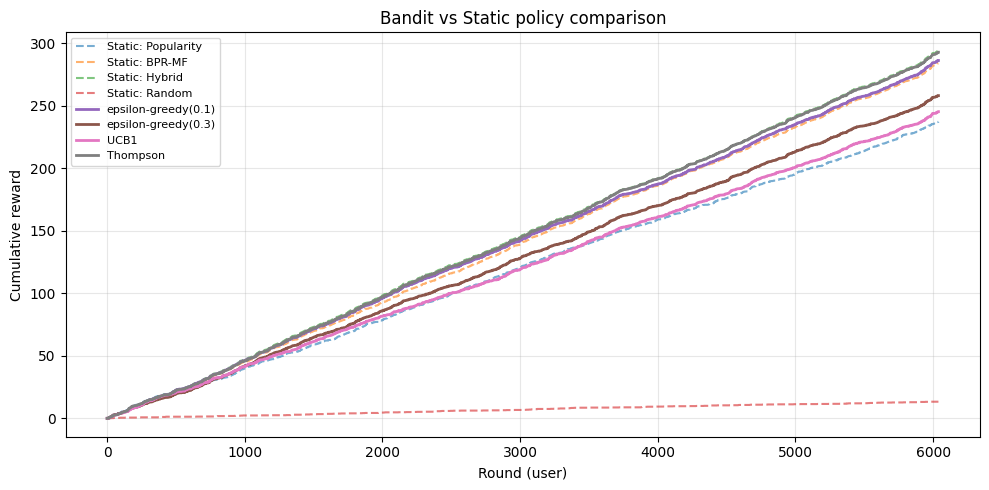

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

for name, rewards in static_rewards.items():
    cum = np.cumsum(rewards)
    ax.plot(cum, label=f"Static: {name}", linestyle="--", alpha=0.6)

for name, rewards in bandit_rewards.items():
    cum = np.cumsum(rewards)
    ax.plot(cum, label=name, linewidth=2)

ax.set_xlabel("Round (user)")
ax.set_ylabel("Cumulative reward")
ax.set_title("Bandit vs Static policy comparison")
ax.legend(fontsize=8, loc="upper left")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../experiments/results/cumulative_reward.png", dpi=150)
plt.show()

In [19]:
print("Average reward per round:")
for name, rewards in static_rewards.items():
    print(f"static {name:12s}: {np.mean(rewards):.4f}")
for name, rewards in bandit_rewards.items():
    print(f"{name:18s}: {np.mean(rewards):.4f}")

Average reward per round:
static Popularity  : 0.0393
static BPR-MF      : 0.0470
static Hybrid      : 0.0487
static Random      : 0.0022
epsilon-greedy(0.1): 0.0474
epsilon-greedy(0.3): 0.0427
UCB1              : 0.0406
Thompson          : 0.0485


static baselines show what the average reward would be if one hardcoded the system to always use exactly one policy for every single user. hybrid and BPR are the best, popularity one is decent, random is almost zero, acting like theoretical minimum

multi-armed bandits start simulation knowing nothing about which static policy is the best. Their average reward includes the penalty of their "learning phase" (pulling bad arms to see if they are good)

Thompson Sampling achieved an average reward almost identical to the theoretical maximum (0.0487). This means it learned almost immediately that the "Hybrid" arm was the best, and successfully shifted almost all of its traffic to that arm

epsilon-greedy are hard-coded to explore completely at random either 10% or 30% of the time. The 0.3 version performed terribly (0.0427) because it permanently wastes 30% of its user traffic pulling sub-optimal arms (like Random and Popularity). The 0.1 version did much better (0.0474) because it wastes less traffic, but it still couldn't beat Thompson Sampling

UCB1 performed surprisingly poorly, barely beating the static Popularity model

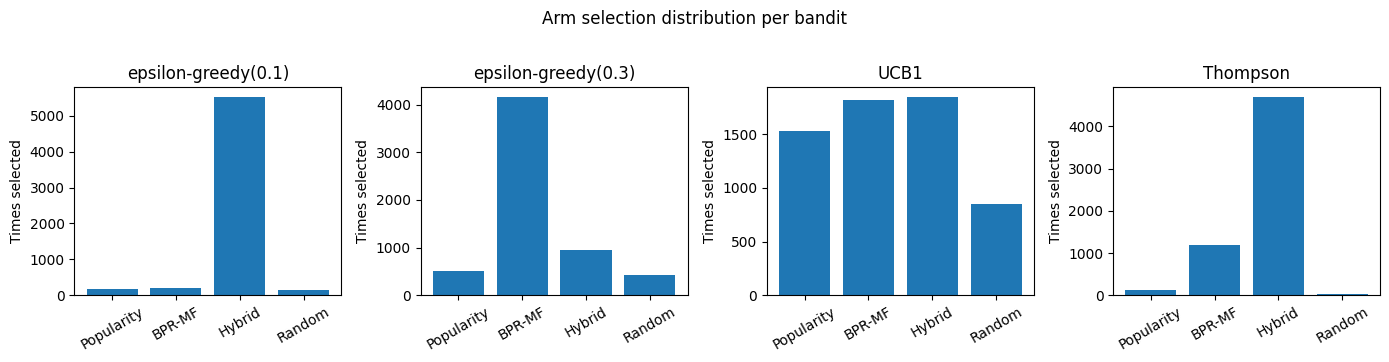

In [20]:
fig, axes = plt.subplots(1, len(bandits), figsize=(14, 3.5))

for ax, (bname, arms) in zip(axes, bandit_arm_history.items()):
    arms = np.array(arms)
    counts = [np.sum(arms == i) for i in range(n_policies)]
    ax.bar(policy_names, counts)
    ax.set_title(bname)
    ax.set_ylabel("Times selected")
    ax.tick_params(axis='x', rotation=30)

plt.suptitle("Arm selection distribution per bandit", y=1.02)
plt.tight_layout()
plt.savefig("../experiments/results/arm_selection.png", dpi=150)
plt.show()

here we check how many times each bandit chose policy

for thompson we have single large hybrid bar, showing that bayesian updates efficiently

epsilon greedy (0.1) has the same picture, surprisingly, even better. (0.3), on the other hand, also has tall bar, though BPR, but other policies are clearly visible and significant 

UCB is flat and evenly (mostly) distributed

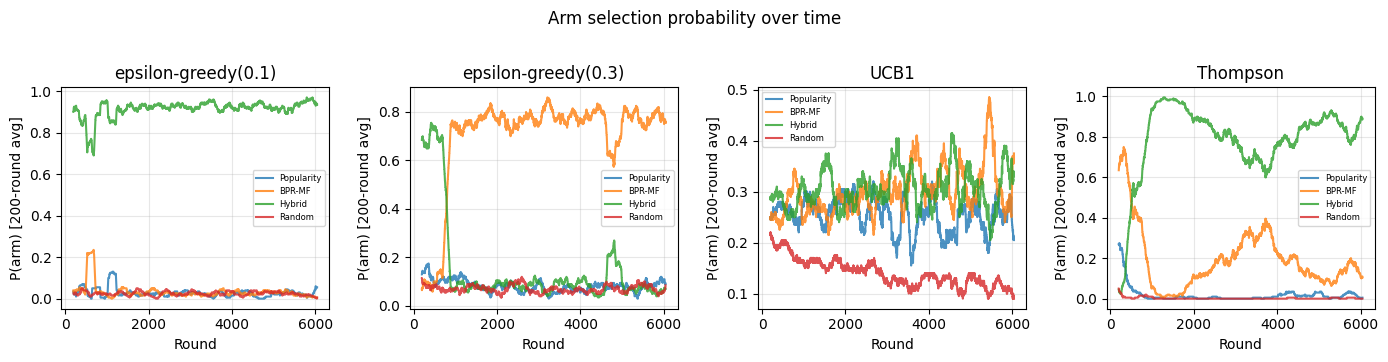

In [21]:
fig, axes = plt.subplots(1, len(bandits), figsize=(14, 3.5))
window = 200

for ax, (bname, arms) in zip(axes, bandit_arm_history.items()):
    arms = np.array(arms)
    for i, pname in enumerate(policy_names):
        rolling = pd.Series((arms == i).astype(float)).rolling(window).mean()
        ax.plot(rolling, label=pname, alpha=0.8)
    ax.set_title(bname)
    ax.set_xlabel("Round")
    ax.set_ylabel(f"P(arm) [{window}-round avg]")
    ax.legend(fontsize=6)
    ax.grid(True, alpha=0.3)

plt.suptitle("Arm selection probability over time", y=1.02)
plt.tight_layout()
plt.savefig("../experiments/results/arm_convergence.png", dpi=150)
plt.show()

on the plot above we can see rolling average of how often bandit chose specific model

for thompson we can see line for the Hybrid model curve smoothly and aggressively upward until it touches the top of the chart, though later falls slightly as bandit chooses BPR a bit more. other lines are effectively zero

for epsilon Hybrid and BPR (for 0.3) line will jump up quickly but hit a hard, flat ceiling (around 0.9 for the 0.1 version, and 0.7 for the 0.3 version). The other lines will remain flat and strictly parallel above zero. never fully commited as math has limits

UCB1 has a messy chart, where lines cross over each other. thus it struggles to separate signal

In [23]:
for bname, bandit in bandits.items():
    if hasattr(bandit, 'counts'):
        counts = bandit.counts
    elif hasattr(bandit, 'alpha'):
        counts = (bandit.alpha - 1) + (bandit.beta - 1)
    total = counts.sum()
    print(f"{bname}:")
    for i, pname in enumerate(policy_names):
        pct = counts[i] / total * 100
        print(f"{pname:12s}: {int(counts[i]):5d} ({pct:5.1f}%)")

epsilon-greedy(0.1):
Popularity  :   175 (  2.9%)
BPR-MF      :   200 (  3.3%)
Hybrid      :  5518 ( 91.4%)
Random      :   147 (  2.4%)
epsilon-greedy(0.3):
Popularity  :   501 (  8.3%)
BPR-MF      :  4157 ( 68.8%)
Hybrid      :   949 ( 15.7%)
Random      :   433 (  7.2%)
UCB1:
Popularity  :  1530 ( 25.3%)
BPR-MF      :  1818 ( 30.1%)
Hybrid      :  1843 ( 30.5%)
Random      :   849 ( 14.1%)
Thompson:
Popularity  :   130 (  2.2%)
BPR-MF      :  1200 ( 19.9%)
Hybrid      :  4691 ( 77.7%)
Random      :    19 (  0.3%)


Thompson: smoothly tested the options, quickly realized "Random" and "Popularity" were garbage, spent some time comparing the two strongest models (BPR-MF and Hybrid), and confidently committed the vast majority of its traffic to the true winner (Hybrid)

epsilon (0.1): successfully found the best model (Hybrid) and exploited it heavily. However, the ~8.6% distributed across the other models represents its hard-coded 10% random exploration. It will never stop sending ~2.5% of users to the terrible "Random" model

epsilon (0.3): Because it randomly explores 30% of the time, the early reward averages were incredibly noisy. By pure bad luck during the early rounds, it mistakenly decided BPR-MF was the best model and got "stuck" exploiting it, completely missing out on the optimal Hybrid model

UCB1: failed to converge. Because the reward values are very small (around 0.04), UCB1's mathematical "uncertainty bonus" was disproportionately large

In [24]:
summary = []
for name, rewards in static_rewards.items():
    summary.append({"Strategy": f"Static:{name}", "Avg_Reward": np.mean(rewards), "Total_Reward": np.sum(rewards)})
for name, rewards in bandit_rewards.items():
    summary.append({"Strategy": name, "Avg_Reward": np.mean(rewards), "Total_Reward": np.sum(rewards)})

pd.DataFrame(summary).to_csv("../experiments/results/bandit_results.csv", index=False)